In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Cityscapes
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from google.colab import drive
drive.mount('/content/drive')



Using PyTorch version: 2.2.1+cu121
No GPU found, using CPU instead.
Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torch.nn.functional as F


class DcCommuteDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.dataset_csv = pd.read_csv(os.path.join(self.root_dir, csv_file))
        print(self.dataset_csv.head())
        self.transform = transform

    def __len__(self):
        return len(self.dataset_csv)

    def __getitem__(self, index):
      if torch.is_tensor(index):
        index = index.tolist()

      # pull index from csv file
      image_name = os.path.join(
          self.root_dir, "images/", self.dataset_csv.iloc[index, 0])
      #seg_filename = os.path.join(
      #    self.root_dir, "semantic/", self.dataset_csv.iloc[index, 0])
      # normalize image from 0-1 off the bat
      return_image = torch.tensor(
          io.imread(image_name)/255, dtype=torch.float).permute(2, 0, 1)
      #return_seg = torch.tensor(
      #    io.imread(seg_filename, as_gray=True), dtype=torch.int)
      if (self.transform):
        return_image = self.transform(return_image)
      #    return_seg = self.transform(return_seg)
      return return_image

In [ ]:
!git clone https://github.com/krmerchant/jhu_midterm

Cloning into 'jhu_midterm'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 196 (delta 115), reused 129 (delta 55), pack-reused 0
Receiving objects: 100% (196/196), 25.07 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [ ]:
## some model paths for checkpointing
## So downstream cells can pull
kitti_model_path_dice_original = '/content/drive/My Drive/kitti-dice-org.pth'
kitti_model_path_loss_tracker_dice_orginal = '/content/drive/My Drive/kitti1-loss-org.pth'


kitti_model_path_dice = '/content/drive/My Drive/kitti-dice.pth'
kitti_model_path_loss_tracker_dice = '/content/drive/My Drive/kitti1-loss.pth'


kitti_model_path_bce = '/content/drive/My Drive/kitti-bce.pth'
kitti_model_path_loss_tracker_bce = '/content/drive/My Drive/kitti1-loss-bce.pth'

root_dir = 'drive/MyDrive/dc_commute/'

      filename
0  image-0.png
1  image-1.png
2  image-2.png
image.shape=torch.Size([3, 256, 256])


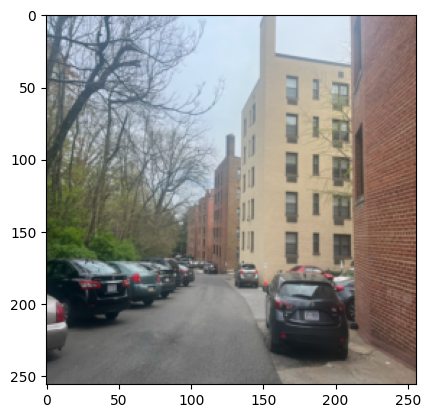

In [ ]:
#Mean: tensor([0.3791, 0.3985, 0.3835])
#Standard deviation: tensor([0.3007, 0.3116, 0.3204])

new_mean = torch.tensor([0.3791, 0.3985, 0.3835])
new_std = torch.tensor([0.3007, 0.3116, 0.3204])
transform = transforms.Compose([
    transforms.Normalize(mean=new_mean, std=new_std)        # Normalize the tensor
])
dc_data = DcCommuteDataset("dataset.csv",root_dir, transforms.Resize((256, 256)))


image = dc_data[2]
numpy_image = image.permute(1, 2, 0).numpy()
print(f"{image.shape=}")
fig, ax = plt.subplots(1, 1)
ax.imshow((numpy_image))


In [ ]:
from datasets import KittiDataset


kitti = KittiDataset('dataset.csv', '/content/drive/MyDrive/data/kitti_semantic/training',car_only=True,  transform=transforms.Compose([transforms.Resize((256, 256))]))

In [ ]:
# @title Default Compute Mean and STD of Kitti



# Initialize variables to accumulate sum of pixel values and sum of squared pixel values
sum_pixel_values = torch.zeros(3)
sum_pixel_values_squared = torch.zeros(3)

# Iterate through the dataset to compute the mean and standard deviation
for image, _ in kitti:
    sum_pixel_values += image.sum(dim=[1, 2])
    sum_pixel_values_squared += (image ** 2).sum(dim=[1, 2])

# Compute the mean and standard deviation
num_images = len(kitti)
mean = sum_pixel_values / (num_images * 256 * 256)
std = torch.sqrt((sum_pixel_values_squared / (num_images * 256 * 256)) - (mean ** 2))

print("Mean:", mean)
print("Standard deviation:", std)

Mean: tensor([0.3791, 0.3985, 0.3835])
Standard deviation: tensor([0.3007, 0.3116, 0.3204])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

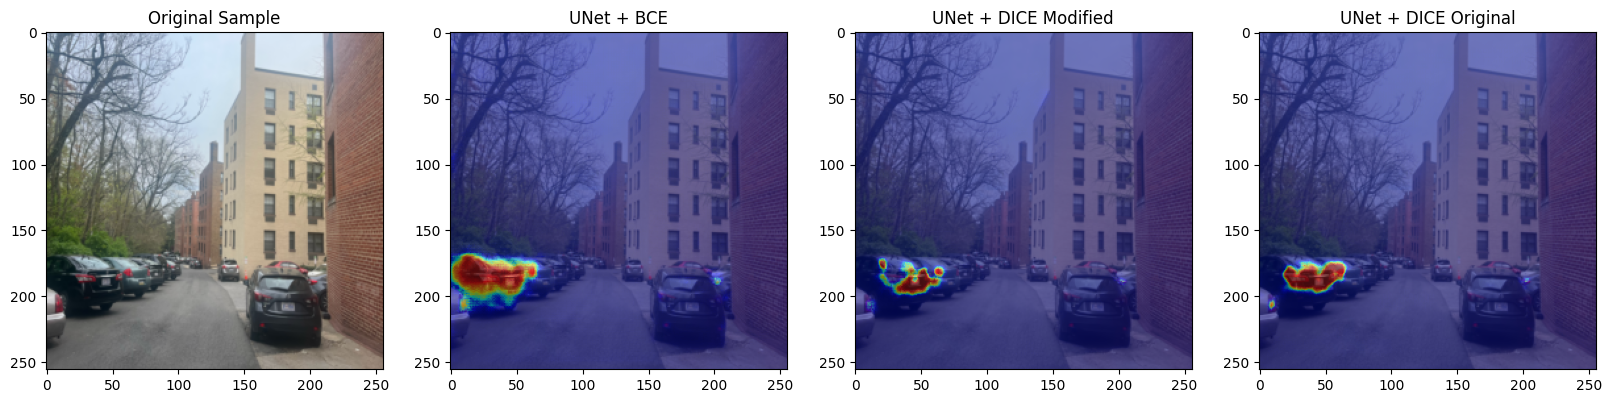

In [ ]:
# @title Qualitative Ground Truth Analysis

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/content/jhu_midterm/src')
from models import UNet
import pickle
from eval_tools import LossTracker

#image,_= kitti[1];
image = dc_data[2];
#image = transform(image)


[c,w,h] = image.shape
image = image.reshape([1,c,w,h])

bce_model = UNet(1 )
dice_mod_model = UNet(1 )
dice_model = UNet(1 )
bce_model.load_state_dict(torch.load(kitti_model_path_bce, map_location=torch.device('cpu')))
dice_mod_model.load_state_dict(torch.load(kitti_model_path_dice, map_location=torch.device('cpu')))
dice_model.load_state_dict(torch.load(kitti_model_path_dice_original, map_location=torch.device('cpu')))
bce_model.eval()
dice_mod_model.eval()
dice_model.eval()
output_bce = bce_model(image)
output_dice_mod= dice_mod_model(image)
output_dice= dice_model(image)




fig,ax = plt.subplots(1,4, figsize=(20,20));
image = image.squeeze().permute(1, 2, 0).numpy();
ax[0].imshow(image)
ax[0].set_title('Original Sample')

#ax[1].imshow(image)
#ax[1].imshow(seg.squeeze(), cmap='jet', alpha=0.5);
#ax[1].set_title('Ground Truth')


seg_im = output_bce.detach()
ax[1].imshow(image)
ax[1].imshow(seg_im.squeeze(), cmap='jet', alpha=0.5);
ax[1].set_title('UNet + BCE')

seg_im = output_dice_mod.detach()
ax[2].imshow(image)
ax[2].imshow(seg_im.squeeze(), cmap='jet', alpha=0.5);
ax[2].set_title('UNet + DICE Modified')


seg_im = output_dice.detach()
ax[3].imshow(image)
ax[3].imshow(seg_im.squeeze(), cmap='jet', alpha=0.5);
ax[3].set_title('UNet + DICE Original')



plt.savefig('test_sample_new.png')
from google.colab import files
files.download('test_sample_new.png')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5535e+04]),
 array([0.56992811, 0.6129353 , 0.6559425 , 0.69894969, 0.74195689,
        0.78496408, 0.82797122, 0.87097842, 0.91398561, 0.95699281,
        1.        ]),
 <BarContainer object of 10 artists>)

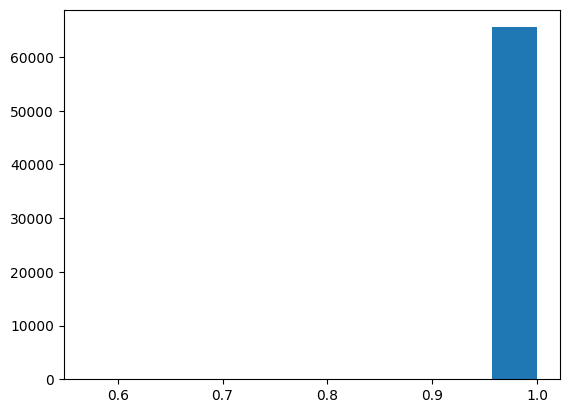

In [ ]:
fig,ax = plt.subplots(1,1)
ax.hist(torch.flatten(seg_im).detach().numpy())


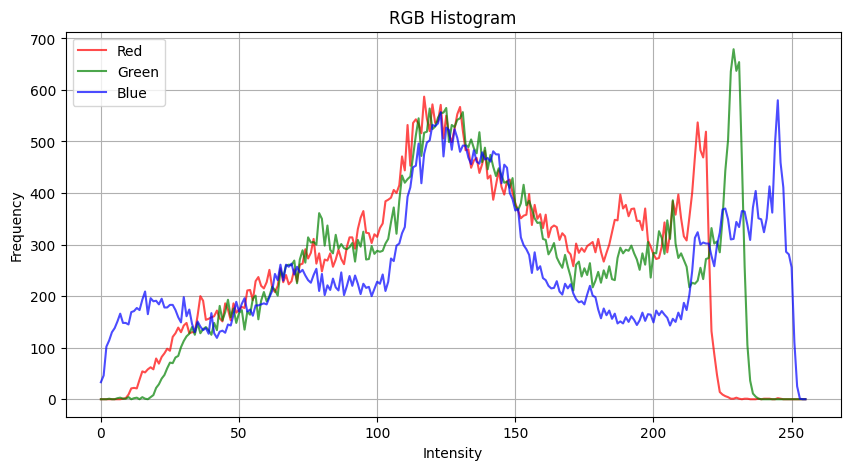

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_rgb_histogram(image_tensor):
    # Convert tensor to numpy array and scale values back to 0-255
    image_np = (image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)  # Assuming tensor is in CHW format

    # Compute histograms
    hist_r, bins_r = np.histogram(image_np[:,:,0].ravel(), bins=256, range=[0,256])
    hist_g, bins_g = np.histogram(image_np[:,:,1].ravel(), bins=256, range=[0,256])
    hist_b, bins_b = np.histogram(image_np[:,:,2].ravel(), bins=256, range=[0,256])

    # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.title('RGB Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.plot(hist_r, color='red', label='Red', alpha=0.7)
    plt.plot(hist_g, color='green', label='Green', alpha=0.7)
    plt.plot(hist_b, color='blue', label='Blue', alpha=0.7)
    plt.legend()
    plt.grid()
    plt.show()


#image,_= kitti[1]
image = transform(dc_data[1])
plot_rgb_histogram(dc_data[1])

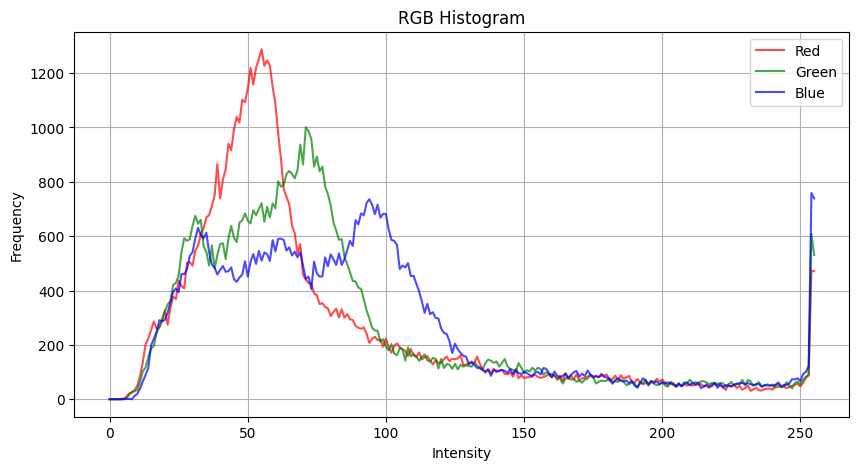

In [ ]:
image,_= kitti[1]
plot_rgb_histogram(image)